In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import os
import numpy as np
import random
from tqdm.auto import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from glob import glob
import cv2
from skimage.io import imread, imshow, show

from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

seed = 42
np.random.seed = seed  # To get same random seed everytime we run the whole thing.
tf.random.set_seed(42)
random.seed(seed)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Import

In [3]:
print(len(os.listdir("/content/drive/MyDrive/ICCIT 2023/Selected_data/H1")))
print(len(os.listdir("/content/drive/MyDrive/ICCIT 2023/Selected_data/H2")))
print(len(os.listdir("/content/drive/MyDrive/ICCIT 2023/Selected_data/H3")))
print(len(os.listdir("/content/drive/MyDrive/ICCIT 2023/Selected_data/H5")))
print(len(os.listdir("/content/drive/MyDrive/ICCIT 2023/Selected_data/H6")))


700
700
700
700
700


In [4]:
dataset= tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/ICCIT 2023/Selected_data')
class_names = dataset.class_names
print(class_names)

Found 3500 files belonging to 5 classes.
['H1', 'H2', 'H3', 'H5', 'H6']


In [5]:
!pip install --root-user-action=ignore split-folders

In [6]:
# Only one time run cell
import splitfolders

input_folder = "/content/drive/MyDrive/ICCIT 2023/Selected_data"
output = "/content/split_data/"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.90, 0.10))

Copying files: 3500 files [01:03, 54.89 files/s] 


## Data Augmentation & Importing Train And Validation Data

In [22]:
image_size = 256
no_class = 5
batch_size = 32
learning_rate = 0.001
num_epochs = 50

In [9]:


data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   vertical_flip=True)

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_directory(
                        '/content/split_data/train',
                        target_size=(image_size, image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True,
                        # seed = 42
                        )

validation_generator = data_generator_no_aug.flow_from_directory(
                        '/content/split_data/val',
                        target_size=(image_size, image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True,
                        # seed = 42
                        )


Found 3150 images belonging to 5 classes.
Found 350 images belonging to 5 classes.


## Using Resnet50 As Base Model & Building the Model

In [11]:


def creat_model():

    base_model = tf.keras.applications.resnet50.ResNet50(
                                                include_top=False,
                                                weights='imagenet',
                                                input_shape=(image_size, image_size, 3),
                                                pooling=None)

    base_model.trainable = False

    input = keras.Input(shape=(image_size, image_size, 3))

    x = base_model(input, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.6)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(no_class, activation="softmax")(x)

    model = keras.Model(inputs = input, outputs = output)

    return model

model = creat_model()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'])

# print(model.summary())

In [12]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                           

In [23]:
# from sklearn.model_selection import StratifiedKFold
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = [] #save accuracy from each fold
history_all = []

for k in range(3):

    print('   ')
    print(f'Training for fold {fold_no} ...', '\n')
    tf.random.set_seed(42+k)
    # x_train = X[train]
    # x_test = X[test]
    # y_train = y[train]
    # y_test = y[test]
    # y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
    # y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)

    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   vertical_flip=True)

    data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = data_generator_with_aug.flow_from_directory(
                        '/content/split_data/train',
                        target_size=(image_size, image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True)

    validation_generator = data_generator_no_aug.flow_from_directory(
                        '/content/split_data/val',
                        target_size=(image_size, image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        shuffle=True)




    # data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
    #                                       layers.RandomRotation(factor=0.02)],
    #                                       name="data_augmentation")

    model = creat_model()

    # optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate,
    #                                  weight_decay=weight_decay)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")])

    history = model.fit(
        train_generator,
        epochs=num_epochs,
        validation_data = validation_generator,
        verbose = 1)

    result = model.evaluate(validation_generator)
    print(f"Test accuracy: {round(result[1] * 100, 2)}%", '\n')

    acc_per_fold.append(result[1]*100)
    history_all.append(history)

    fold_no = fold_no + 1


   
Training for fold 1 ... 

Found 3150 images belonging to 5 classes.
Found 350 images belonging to 5 classes.
Epoch 1/50
99/99 [==============================] - 21s 173ms/step - loss: 1.2883 - accuracy: 0.5537 - val_loss: 0.7443 - val_accuracy: 0.7143
Epoch 2/50
99/99 [==============================] - 15s 150ms/step - loss: 0.8702 - accuracy: 0.6581 - val_loss: 0.7019 - val_accuracy: 0.6914
Epoch 3/50
99/99 [==============================] - 15s 149ms/step - loss: 0.7448 - accuracy: 0.6984 - val_loss: 0.6743 - val_accuracy: 0.7114
Epoch 4/50
99/99 [==============================] - 15s 150ms/step - loss: 0.7169 - accuracy: 0.7171 - val_loss: 0.6645 - val_accuracy: 0.7343
Epoch 5/50
99/99 [==============================] - 15s 153ms/step - loss: 0.6734 - accuracy: 0.7251 - val_loss: 0.5920 - val_accuracy: 0.7686
Epoch 6/50
99/99 [==============================] - 16s 158ms/step - loss: 0.6340 - accuracy: 0.7451 - val_loss: 0.5868 - val_accuracy: 0.7629
Epoch 7/50
99/99 [===========

## Training

In [17]:
print(acc_per_fold, '\n')

mean = np.mean(np.array(acc_per_fold))
std = np.std(np.array(acc_per_fold))

print(f"Overall Accuracy is : {mean}+-{std}")

[77.99999713897705, 74.57143068313599, 75.99999904632568] 

Overall Accuracy is : 76.19047562281291+-1.406171630153389


In [19]:
history_nparray = np.zeros((12, 10))
print(len(history_all[0].history))

count = 0

for k in tqdm(range(3)):

    aa = history_all[k].history      # Dictionary

    history_nparray[count, :] = np.array(aa['loss'])
    count = count+1
    history_nparray[count, :] = np.array(aa['accuracy'])
    count = count+1
    history_nparray[count, :] = np.array(aa['val_loss'])
    count = count+1
    history_nparray[count, :] = np.array(aa['val_accuracy'])
    count = count+1

print(count)
print(history_nparray[-1,:])

4


  0%|          | 0/3 [00:00<?, ?it/s]

12
[0.69428569 0.72571427 0.74000001 0.76285714 0.79428571 0.75714284
 0.76285714 0.77999997 0.78285712 0.75999999]


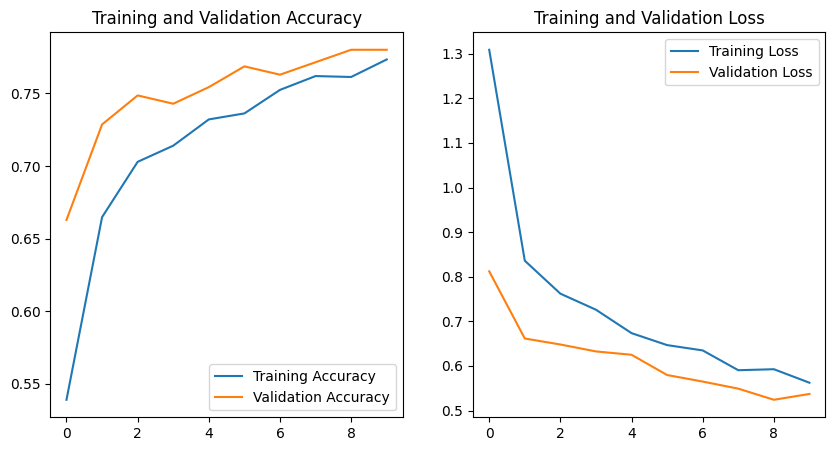

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(10), history_nparray[1,:], label='Training Accuracy')
plt.plot(range(10), history_nparray[3,:], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), history_nparray[0,:], label='Training Loss')
plt.plot(range(10), history_nparray[2,:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('defungi.h5')

In [ ]:
new_model = creat_model()

new_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'])

new_model.load_weights("/content/defungi.h5")

print(new_model.evaluate(train_generator))

99/99 [==============================] - 15s 134ms/step - loss: 0.1517 - categorical_accuracy: 0.9562
[0.1517055183649063, 0.9561904668807983]
